In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
import tensorflow as tf
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)


# Load MNIST and some preprocessing

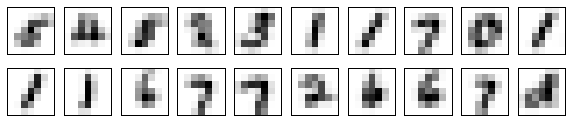

In [20]:
from keras.datasets import mnist
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

(ntrain, xdim, ydim) = Xtrain.shape
ntest = Xtest.shape[0]

# split train data in two parts
X_pr = Xtrain[30000:60000, :, :]
Y_pr = Ytrain[30000:60000]

Xtrain = Xtrain[0:30000, :, :];
Ytrain = Ytrain[0:30000]

# DOWNSAMPLE THE IMAGES
factor = 0.25

Xtrain_down = np.ones((Xtrain.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtrain.shape[0]):
    Xtrain_down[i, :, :] = imresize(Xtrain[i,:,:], factor)

Xtest_down = np.ones((Xtest.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtest.shape[0]):
    Xtest_down[i,:,:] = imresize(Xtest[i,:,:], factor)

    
X_pr_down = np.ones((X_pr.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(X_pr.shape[0]):
    X_pr_down[i,:,:] = imresize(X_pr[i,:,:], factor)

    
# VECTORIZE IMAGES
Xtrain_down = Xtrain_down.reshape(Xtrain.shape[0], int(xdim*factor)**2).astype('float32') / 255
Xtest_down  = Xtest_down.reshape(ntest, int(xdim*factor)**2).astype('float32') / 255
X_pr_down   = X_pr_down.reshape(X_pr.shape[0], int(xdim*factor)**2).astype('float32') / 255
Xtrain      = Xtrain.reshape(Xtrain.shape[0], xdim**2).astype('float32') / 255
Xtest       = Xtest.reshape(ntest, xdim**2).astype('float32') / 255

# Categorical labels
Ytrain_cat = np_utils.to_categorical(Ytrain, 10)
Ytest_cat = np_utils.to_categorical(Ytest, 10)

# VISUALIZATION 20 RANDOM TRAINING SAMPLES
# Create 20 subplots
fig, axes = plt.subplots(2, 10, figsize=(10, 2))

for i in range(2):
    for j in range(10):
        axes[i][j].imshow(Xtrain_down[np.random.randint(0, 3000),:].reshape(int(xdim*factor), 
                          int(ydim*factor)), cmap='gray_r', interpolation='nearest')
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        

# TRAIN A FULLY-CONNECTED NN WITH 4 "LINEAR" HIDDEN LAYERS 

In [21]:
# create model
model = Sequential()
model.add(Dense(128, input_shape=(int(xdim*factor)**2,)))
model.add(Dense(128))
model.add(Dense(128))
model.add(Dense(128))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
with with tf.device('/gpu:0'):
    model.fit(Xtrain_down, Ytrain_cat, nb_epoch=50, batch_size=32)

# evaluate the model
scores = model.evaluate(Xtest_down, Ytest_cat, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# # calculate predictions
# Ypredict = model.predict(Xtest)
# # round predictions
# rounded = [round(x[0]) for x in Ypredict]
# print(rounded)

# Save the model
model.save('linear_nn.h5')

# GET THE OUTPUT OF EACH LAYER AFTER TRAINING
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
layer_outs = functor([X_pr_down, 1.])                       # compute on 2nd training set
layer_outs_test = functor([Xtest_down, 1.])                 # compute on test set
#print(layer_outs)


Epoch 1/50
30000/30000 [==============================] - 4s - loss: 0.4972 - acc: 0.8487     
Epoch 2/50
30000/30000 [==============================] - 4s - loss: 0.4024 - acc: 0.8801     
Epoch 3/50
30000/30000 [==============================] - 4s - loss: 0.3936 - acc: 0.8850     
Epoch 4/50
30000/30000 [==============================] - 4s - loss: 0.3903 - acc: 0.8842     
Epoch 5/50
30000/30000 [==============================] - 4s - loss: 0.3873 - acc: 0.8849     
Epoch 6/50
30000/30000 [==============================] - 4s - loss: 0.3847 - acc: 0.8864     
Epoch 7/50
30000/30000 [==============================] - 4s - loss: 0.3799 - acc: 0.8881     
Epoch 8/50
30000/30000 [==============================] - 4s - loss: 0.3822 - acc: 0.8893     
Epoch 9/50
30000/30000 [==============================] - 4s - loss: 0.3765 - acc: 0.8907     
Epoch 10/50
30000/30000 [==============================] - 4s - loss: 0.3725 - acc: 0.8922     
Epoch 11/50
30000/30000 [========================

# subsample and do xgboost regression

In [23]:
from copy import copy, deepcopy
from RE_PartialRecData import RE_PartialRecData
import os
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier
import pickle

params = {}
# use softmax multi-class classification 'multi:softmax'
# use linear regression 'reg:linear'
params['objective'] = 'reg:linear'
# scale weight of positive examples
params['eta'] = 0.4
params['max_depth'] = 6
params['silent'] = 1
params['nthread'] = 4
# params['num_class'] = 10
num_round=5

# how many recordings?
nRecordings = 10
# how many neurons from the firs hidden layer?
subnetSize = [2**x for x in range(8)]
nSubnetSize = len(subnetSize)
# which layers?
# how many samples per recording?
nSamples = np.divide(int(X_pr_down.shape[0]/nRecordings),subnetSize)
# how many iterations
nIterations = 50

# baseline prediction error
#bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

oLayer = len(layer_outs)-1  # index of output layer
nOutNeurons = layer_outs[oLayer].shape[1]
rmses = np.zeros([nIterations, nOutNeurons, nSubnetSize])

for ss in range(nSubnetSize):
    nLayerNeurons = [subnetSize[ss], 0, 0, 0, 10]
    print(subnetSize[ss])
    for it in range(nIterations):
        # copy data
        layer_outputs = deepcopy(layer_outs)
        # subsample
        X_subsample, Y_subsample = RE_PartialRecData(layer_outputs, nLayerNeurons, nRecordings, nSamples[ss])
        #print('# nan neurons: ',np.count_nonzero(np.isnan(X_subsample[:3000,:]).sum(axis=0)))
        # prepare data for xgboost
        for iN in range(nOutNeurons):
            #print('#neuron, #iteratin, subnetsize: ', iN,it,subnetSize[ss])
            xg_train  = xgb.DMatrix(X_subsample, label=Y_subsample[:, iN])
            xg_test   = xgb.DMatrix(layer_outs_test[0], label=layer_outs_test[3][:,iN])
            watchlist = [(xg_train, 'train'), (xg_test, 'test')]
            # train XGboost
            bst = xgb.train(params, xg_train, num_round, watchlist, verbose_eval=True)
            # get predictions
            pred = bst.predict(xg_test)
            rmses[it,iN,ss] = np.sqrt(np.mean(np.square([(pred[i] - layer_outs_test[3][:,iN][i]) 
                                         for i in range(len(layer_outs_test[3][:,1]))])))
            #print ('predicting, RMSE=%f' %rmses[it, iN, ss])
            

# save the rmse's
with open('RMSE_Layer1_Linear.dat','wb') as f:
    pickle.dump(rmses, f)
f.close()

1


NameError: name 'layer_outs_test' is not defined